<font size="10">Simulating Diffusion with PINNs</font>

<font size="4">This notebook employs a physics informed neural network (PINN) to simulate the solution to the linear diffusion equation
$\partial_t u = \partial_x^2u,$
with $x \in [-1,1]$ and $t\in [0,1]$. The initial condition is taken to be $u(x,0) = \cos(\pi x)$ and we consider Neumann boundary conditions.</font>

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 4.4 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf. The general PINN framework here is adapted from the PINN in the repository [janblechschmidt/PDEsbyNNS](https://github.com/janblechschmidt/PDEsByNNs) from GitHub user [Jan Blechschmidt](https://github.com/janblechschmidt).</font>

In [13]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = 0.1

# Define initial condition
def fun_u_0(x):
    return tf.cos(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(u_t, u_xx):
    return u_t - viscosity * u_xx

In [14]:
# Set number of data points
N_0 = 500
N_b = 1000
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

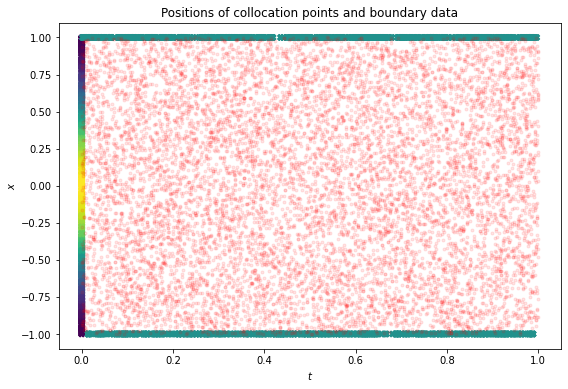

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

In [16]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [17]:
def compute_loss(model, X_r, X_data, u_data):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))
        #ub = model(tf.stack([tb[:,0], xb[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape
    
    loss = tf.reduce_mean(tf.square(fun_r(u_t, u_xx)))

    # Initial conditions in loss
    u0 = model(X_data[0])
    loss += tf.reduce_mean(tf.square(u_data[0] - u0))
    
    # Neumann Boundary conditions
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        tb, xb = X_data[1][:,0:1], X_data[1][:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(tb)
        tape.watch(xb)

        # Determine residual 
        ub = model(tf.stack([tb[:,0], xb[:,0]], axis=1))
        #ub = model(tf.stack([tb[:,0], xb[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        ub_x = tape.gradient(ub, xb)

    del tape
    
    # Neumann BCs
    loss += tf.reduce_mean(tf.square(ub_x))
    
    return loss

In [18]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [19]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [20]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.60381055e-01
It 00050: loss = 1.32044852e-01
It 00100: loss = 1.63244933e-01
It 00150: loss = 7.99431931e-03
It 00200: loss = 7.73405004e-03
It 00250: loss = 2.05230415e-02
It 00300: loss = 1.30989570e-02
It 00350: loss = 1.63344443e-02
It 00400: loss = 4.76328246e-02
It 00450: loss = 3.42845209e-02
It 00500: loss = 1.90741953e-03
It 00550: loss = 3.01272282e-03
It 00600: loss = 5.31216990e-03
It 00650: loss = 1.05181988e-02
It 00700: loss = 7.53859349e-04
It 00750: loss = 2.36922340e-03
It 00800: loss = 2.83030304e-03
It 00850: loss = 9.48987342e-03
It 00900: loss = 3.21417814e-03
It 00950: loss = 3.54653737e-03
It 01000: loss = 2.91027478e-03
It 01050: loss = 4.66873054e-04
It 01100: loss = 3.95675859e-04
It 01150: loss = 3.57544544e-04
It 01200: loss = 3.28437687e-04
It 01250: loss = 3.04817600e-04
It 01300: loss = 2.84909154e-04
It 01350: loss = 2.67666706e-04
It 01400: loss = 2.52419937e-04
It 01450: loss = 2.38717417e-04
It 01500: loss = 2.26245073e-04
It 01550

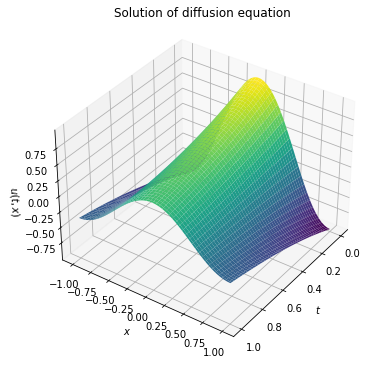

In [23]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('Solution of diffusion equation');

In [26]:
# Save plot and export to MATLAB
import scipy.io

# Save data as .mat file
scipy.io.savemat('diffusion_sol.mat', dict(U = U, X = X, T = T))
# This data is used in the MATLAB script plot_diffusion.m to plot 
#      the PINN solution and compare the final state